# FPP multi objective optimization

### Setup distributed computing environment

See more details here: https://fuse.help/parallel.html

In [14]:
if gethostname() == "saga.cluster"
    nodes = 4
    np = 30 * nodes
    using Pkg
    Pkg.activate("..")
    using Distributed
    using ClusterManagers
    ENV["JULIA_WORKER_TIMEOUT"] = "180"
    if nprocs() < np
        addprocs(SlurmManager(np-nprocs()), exclusive="", topology=:master_worker)
    end
else
    using Distributed
    np = 4
    if nprocs() < np + 1
        addprocs(np-nprocs()+1, topology=:master_worker)
    end
end
println("Working with $(nprocs()) processes")

Working with 5 processes


### Import packages

In [15]:
using Revise
using FUSE
using Plots; gr();
global_logger(FUSE.logger);

### Get `ini` and `act` for FPP case and custmize as needed

In [16]:
ini, act = FUSE.case_parameters(:FPP; version=:v1_demount, init_from=:scalars)
ini.core_profiles.zeff = 2.0
act.ActorPFcoilsOpt.optimization_scheme = :none; # don't spend time optimizing the PFs

### As a good practice, test the actor/workflow that you want to optimize first

In [17]:
dd = FUSE.init(ini, act)
FUSE.ActorWholeFacility(dd, act);

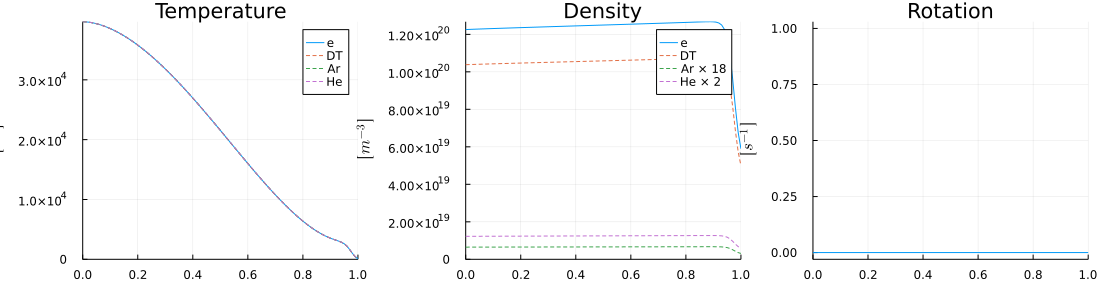

In [18]:
#IMAS.freeze(dd.balance_of_plant)
plot(dd.core_profiles)

### Define optimization variables and ranges

In [19]:
# nominal value and ranges
ini.core_profiles.zeff = 2.0 ↔ [1.1, 2.5]
ini.core_profiles.greenwald_fraction = 0.9 ↔ [0.8, 0.95]
ini.ec_launchers.power_launched = 45e6 ↔ [20e6, 60e6];

### Define the optimization objectives

In [20]:
# FUSE comes with a library of objective functions
OFL = FUSE.ObjectivesFunctionsLibrary
objective_functions = [OFL[:max_power_electric_net], OFL[:min_cost], OFL[:max_log10_flattop]]

# ...but one can define custom optimization objectives too
# target_power_electric = FUSE.ObjectiveFunction(:target_power_electric_net, "MW", dd -> @ddtime(dd.balance_of_plant.power_electric_net)/1E6, 200)
# objective_functions = [target_power_electric, OFL[:min_cost], OFL[:max_flattop]]

3-element Vector{FUSE.ObjectiveFunction}:
 max_power_electric_net [MW]
 min_cost [$M]
 max_log10_flattop [log₁₀(hours)]

### Setup and run optimization

In [26]:
# option to resume an optimization where it was left off
if true
    continue_results = missing
else
    continue_results = results
end

# define optimization parameters
# For real optimization studies the population size (N) and number of iterations should be bigger
# eg. N=100, iterations=25
optimization_parameters = Dict(
    :N => max(4, Int(floor((nprocs()-1)/2))*2), # even number
    :iterations => 10,
    :continue_results => continue_results)

# run optimization
results = FUSE.workflow_multiobjective_optimization(ini, act, FUSE.ActorWholeFacility, objective_functions; optimization_parameters...);

Running on 4 worker processes
== Actuators ==
ini.ec_launchers.power_launched
- units: W
- description: EC launched power
- value: 4.5e7
- base: 4.5e7
- default: missing
- lower: 2.0e7
- upper: 6.0e7
ini.core_profiles.zeff
- units: 
- description: Effective ion charge
- value: 2.0
- base: 1.1
- default: missing
- lower: 1.1
- upper: 2.5
ini.core_profiles.greenwald_fraction
- units: 
- description: Greenwald fraction, ne_vol / ne_gw
- value: 0.9
- base: 0.9
- default: missing
- lower: 0.8
- upper: 0.95

== Objectives ==
max_power_electric_net [MW]
min_cost [$M]
max_log10_flattop [log₁₀(hours)]



Iteration 100%|████████████████████████████| Time: 0:07:09 (42.92  s/it)


453.246778 seconds (20.78 M allocations: 1.093 GiB, 0.13% gc time, 1.65% compilation time)


### Save optimization results to file

In [22]:
filename = "optimization.bson"
#@time FUSE.save_optimization(filename, results)

# Optimization results can be re-loaded this way:
#@time results = FUSE.load_optimization(filename);

### Plot multi-objective optimization results

In [27]:
using Plots; gr();
using Interact

design_space=false
pareto=false
if design_space
    xlim = [results.opt_ini[1].lower, results.opt_ini[1].upper]
    ylim = [results.opt_ini[2].lower, results.opt_ini[2].upper]
    zlim = [results.opt_ini[3].lower, results.opt_ini[3].upper]
else
    xlim = [0, 200]
    ylim = [1800, 1900]
    zlim = [0, 5]
end
@manipulate for iteration in 1:25
    iterations=iteration:iteration
    p=[]
    for k in [1,2,3]
        push!(p, plot(results, [1,2,3]; design_space, pareto, color_by=k, max_samples=nothing, iterations, xlim, ylim, zlim, labelfontsize=8,titlefontsize=10, margin=5Plots.mm))
    end
    plot(p...,layout=(1,3),size=(1200,300))
end


Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["iteration"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 25, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Int64} with 2 listeners. Value:
13, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/slendebroek/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/slendebroek/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/slendebroek/.julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), Asset("css", nothing, "/Users/slendebroek/.julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), Asset("css", nothing, "/Users/slendebroek/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000017ed653c0, Task (runnable) @0x000000017ed653c0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"82598705561

In [31]:
# Import the `plotlyjs()` plotting backend instead of the usual `gr()`to interactively look at results in 3D
#using Plots; plotlyjs();
#pareto=true
#plot(results, [1,2,3]; design_space, pareto, color_by=2, max_samples=nothing, iterations=25:25)

### How to: Define and use a custom FUSE workflow

In [32]:
# Here `@everywhere` is needed to make all processes aware of the custom function
@everywhere function workflow_custom(ini,act)
    FUSE.init(dd, ini, act)
    FUSE.ActorEquilibriumTransport(dd, act)
    FUSE.ActorCXbuild(dd, act)
    return dd
end

# results = FUSE.workflow_multiobjective_optimization(ini, act, custom_workflow, objective_functions; optimization_parameters...);